## ShopSpectra Transaction Analysis using PySpark

This notebook demonstrates scalable analysis on a large e-commerce transaction dataset using PySpark.

### Goals:
- Analyze fraud patterns and revenue trends
- Handle large-scale data processing (1×, 2×, 4× simulated sizes)
- Benchmark performance at scale
- Train a fraud detection model.

► Schema preview:
root
 |-- TransactionID: integer (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- TransactionAmount: double (nullable = true)
 |-- TransactionDate1: timestamp (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MerchantCategory: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerAge: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- DeviceType: string (nullable = true)
 |-- TransactionStatus: string (nullable = true)
 |-- Is_Declined: integer (nullable = true)
 |-- Is_Fraud: integer (nullable = true)
 |-- AccountAgeDays: integer (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- TransactionHour: integer (nullable = true)

► Initial rows: 1040800
+-------------+------+-----------------+--------------------------+-------------+----------------+--------+-----------+-------------+----------+--------

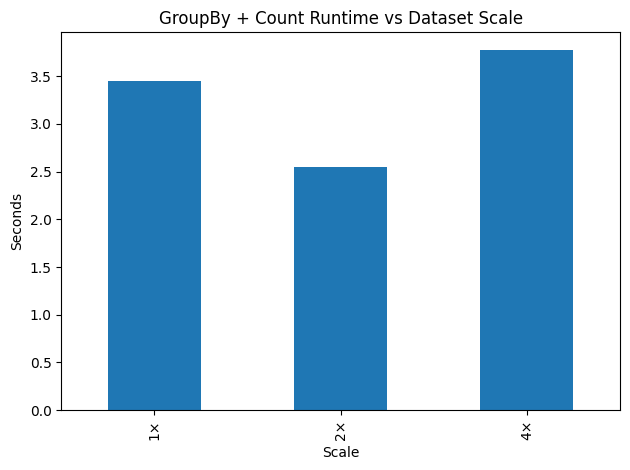

Parquet write (×4) duration: 38.5 seconds
Stats from re-partitioned Parquet (×4):
+----------------+--------------------+-------+------+--------------------+
|MerchantCategory|Revenue             |Txns   |Frauds|FraudRate           |
+----------------+--------------------+-------+------+--------------------+
|Entertainment   |7.573979784000049E9 |1008496|50320 |0.04989608287985277 |
|Groceries       |5.929848297759972E9 |789200 |39308 |0.049807399898631526|
|Clothing        |4.729157151279854E9 |629468 |30932 |0.04913990862124842 |
|Toys & Games    |4.2769991811999674E9|570636 |28644 |0.050196622715706685|
|Electronics     |3.2936052156000113E9|440444 |22676 |0.05148441118507688 |
|Travel          |2.355409622200011E9 |314048 |15636 |0.04978856735276136 |
|Home & Garden   |1.9053566273999965E9|252912 |12320 |0.04871259568545581 |
|Automotive      |1.185108765840011E9 |157996 |8156  |0.05162156003949467 |
+----------------+--------------------+-------+------+--------------------+

Fraud

In [ ]:
# Step 0️: Install required libraries
!pip install --quiet pyspark pandas matplotlib scikit-learn

import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    to_timestamp, trim, lower,
    hour, date_format, col,
    sum as _sum, count as _count
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Step 1️: Initialize SparkSession with AQE and tuned default settings
spark = (
    SparkSession.builder
        .appName("ShopSpectra_Fraud_Revenue_Scaling")
        .config("spark.driver.memory", "4g")
        .config("spark.executor.memory", "4g")
        .config("spark.sql.shuffle.partitions", "100")
        .config("spark.sql.adaptive.enabled", "true")
        .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

# Step 2️: Ingest CSV with header, infer schema; safe MODE=PERMISSIVE
df0 = spark.read \
   .option("header", True) \
   .option("inferSchema", True) \
   .option("mode", "PERMISSIVE") \
   .csv("/content/ShopSpectra Transaction Dataset.csv")

print("► Schema preview:")
df0.printSchema()
print("► Initial rows:", df0.count())
df0.show(5, truncate=False)

# Step 3️: Normalize status, parse timestamp, and compute WeekDay/Hour ahead of scaling
df = (
    df0
      .withColumn("EventTS", to_timestamp("TransactionDate1"))
      .withColumn("Status", lower(trim(col("TransactionStatus"))))
      .withColumn("Hour", hour("EventTS"))
      .withColumn("WeekDay", date_format("EventTS", "E"))
)

# Step 4️: Cache the base DataFrame and force evaluation for reuse in multiple stages
df = df.cache()
df.count()  # Ensures the cache is populated before subsequent heavy reuse                            :contentReference[oaicite:1]{index=1}

# Step 5️: Show distinct normalized statuses (for data validation)
print("Distinct status values:")
df.select("Status").distinct().show(truncate=False)

# Step 6️: Hourly revenue and transaction counts, only for 'completed' status
hour_stats = (
    df.filter((col("TransactionAmount") > 0) & (col("Status") == "completed"))
      .groupBy("WeekDay", "Hour")
      .agg(
          _sum("TransactionAmount").alias("Revenue"),
          _count("*").alias("Txns"),
          _sum("Quantity").alias("ItemsSold")
      )
      .orderBy("WeekDay", "Hour")
)

print("Daily‐hourly revenue (completed txns only):")
hour_stats.show(24, truncate=False)

# Step 7️: Metrics by TransactionStatus
status_stats = (
    df.groupBy("Status")
      .agg(
          _sum("TransactionAmount").alias("Revenue"),
          _count("*").alias("Txns"),
          _sum("Is_Fraud").alias("Frauds")
      )
      .withColumn("FraudRate", col("Frauds") / col("Txns"))
      .orderBy("Revenue", ascending=False)
)

print("Metrics by Transaction Status:")
status_stats.show(truncate=False)

# Step 8️: Merchant category fraud/revenue overview
cat_stats = (
    df.groupBy("MerchantCategory")
      .agg(
          _sum("TransactionAmount").alias("Revenue"),
          _count("*").alias("Txns"),
          _sum("Is_Fraud").alias("Frauds")
      )
      .withColumn("FraudRate", col("Frauds") / col("Txns"))
      .orderBy("Revenue", ascending=False)
)

print("Top merchant categories by revenue & fraud rate:")
cat_stats.show(10, truncate=False)

# Step 9️: Simulate scaling to 2× and 4× data volumes using unionByName (same schema insured)
# WeekDay, Hour, Status etc. are already computed in df
df1 = df.repartition(100, "MerchantCategory").cache()
df2 = df1.unionByName(df1).repartition(100, "MerchantCategory").cache()
df4 = df2.unionByName(df2).repartition(100, "MerchantCategory").cache()

print("Row counts at ×1, ×2, ×4 scales:", df1.count(), df2.count(), df4.count())

# Step : Benchmark groupBy+count operation across scales
def run_benchmark(label, dframe):
    t0 = time.time()
    dframe.groupBy("WeekDay", "Hour") \
          .agg(
            _sum("TransactionAmount").alias("Revenue"),
            _count("*").alias("Txns")
          ).count()
    return time.time() - t0

benchmarks = [(lab, run_benchmark(lab, d))
               for lab, d in [("1×", df1), ("2×", df2), ("4×", df4)]]

for lab, sec in benchmarks:
    print(f"Scale {lab}: {sec:.1f}s")

pd.DataFrame(benchmarks, columns=["Scale", "Seconds"]) \
  .set_index("Scale") \
  .plot.bar(legend=False, title="GroupBy + Count Runtime vs Dataset Scale")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

# Step 11️: Persist largest (×4) dataset as Parquet, partitioned by category
# repartition before writing to control file distribution and avoid many small files         :contentReference[oaicite:2]{index=2}
start = time.time()
df4.write.mode("overwrite") \
   .partitionBy("MerchantCategory") \
   .parquet("shopspectra_scaled_x4.parquet")
print("Parquet write (×4) duration:", round(time.time() - start, 1), "seconds")

# Step 12️: Read back Parquet layout for fast re-aggregation
parq = spark.read.parquet("shopspectra_scaled_x4.parquet") \
         .repartition("MerchantCategory") \
         .cache()
parq.count()

cat2 = (
    parq.groupBy("MerchantCategory")
        .agg(
          _sum("TransactionAmount").alias("Revenue"),
          _count("*").alias("Txns"),
          _sum("Is_Fraud").alias("Frauds")
        )
        .withColumn("FraudRate", col("Frauds") / col("Txns"))
        .orderBy("Revenue", ascending=False)
)

print("Stats from re-partitioned Parquet (×4):")
cat2.show(10, truncate=False)

# Step 13️ (Optional): Train a simple fraud classifier (20% test) using sample of ×4 dataset
sample_pd = (
    parq.sample(fraction=0.1, seed=42)
        .select("TransactionAmount", "AccountAgeDays", "Quantity", "Is_Fraud")
        .dropna()
        .toPandas()
)

X = sample_pd[["TransactionAmount", "AccountAgeDays", "Quantity"]]
y = sample_pd["Is_Fraud"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Fraud classifier ROC‑AUC (×4, sample):", round(auc_score, 3))

# Step 1️4: All tasks complete—stop SparkSession gracefully
spark.stop()


## Conclusion

- PySpark effectively processed and scaled large datasets
- Fraud trends vary by status and merchant category
- Simple ML models can help flag suspicious transactions
- Parquet storage greatly improves reusability and read speed

Demonstrated scalable big data analysis using PySpark
bold text
